# Deliverable 3: Preprocessing the Data for a Neural Network (reuse code from D1/D2) 

## Results
    | Model Trial          | Loss     | Accuracy  | Comments | 
    | :------------------- | :------- | :-------- | :------- | 
    | Base Model (D1/D2)   | 0.5540   | 0.7286    | Basic data cleanup / encoding, one hidden layer (RELU, 22), 50 epoch   | 
    | Option 1             | 0.5537   | 0.7277    | Add a second hidden layer (RELU, 11), 50 epoch                         | 
    | Option 2             | 0.5559   | 0.7303    | Increase the neurons from (22, 11) to 32,16), 50 epoch          | 
    | Option 3             | 0.5644   | 0.7276    | Option 2 plus increase to 200 epoch          | 


In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import numpy as np

#  Import and read the charity_data.csv.
import pandas as pd 
charity_df = pd.read_csv("Resources/charity_data.csv")
charity_df

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...,...,...
34294,996009318,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,996010315,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,996012607,PTA HAWAII CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,996015768,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [2]:
# Target: IS_SUCCESSFUL
# Features:'APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION','USE_CASE', 'ORGANIZATION', 'STATUS', 'INCOME_AMT',
#          'SPECIAL_CONSIDERATIONS', 'ASK_AMT'

In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
charity_df.drop(['EIN', 'NAME'],inplace=True, axis=1)

### Explore ASK_AMT column for exteme values...
While there are a few (~100) rows with an ask > 100,000,000, there were 33 that were successful
So I made no changes - scaling will help and removing large succesful requests just seems wrong

I also explored using bins, but that did not yield any addtional improvement so it is not included (commented below)


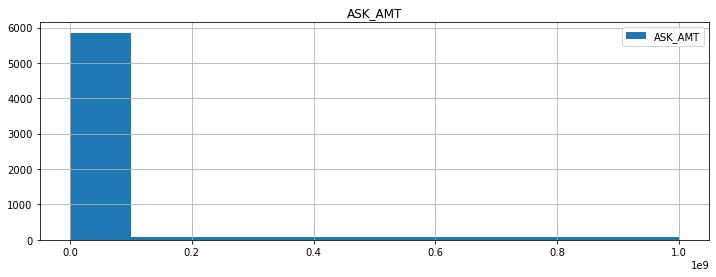

In [3]:
hist = charity_df.hist('ASK_AMT', bins=[50000, 100000000, 1000000000 ], legend=True, figsize=(12,4))

In [4]:
# create a new ADJ column by remapping ASK_MAT to 0/1 based on value
# charity_df['ASK_AMT_ADJ'] = charity_df['ASK_AMT'].apply(lambda x: 1 if x <= 50000 else 0 )
#
# display counts
# charity_df.ASK_AMT_ADJ.value_counts()
#    1    28345
#    0     5954
#    Name: ASK_AMT_ADJ, dtype: int64
#
# Drop the orgrignal col
# charity_df.drop(['ASK_AMT'],inplace=True, axis=1)
#
# post the above steps just ran the same steps below, but no signifcant variance in model results.

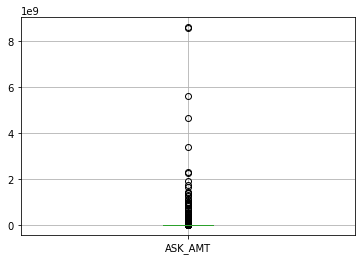

In [4]:
# explore if ASK_AMT for data quality
boxplot = charity_df.boxplot(column=['ASK_AMT'])
#charity_df.dtypes

In [5]:
# calculate quartiles 
quartiles = np.quantile(charity_df['ASK_AMT'],[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)

temp_list=[]
# collect the the potential outliers
potential_outliers = [temp_list.append(ask) if ask < lower_bound or ask > upper_bound else next for ask in charity_df['ASK_AMT']]

In [6]:
# how many ask for over 100MM?
ask_df = pd.DataFrame(temp_list, columns=['ASK_AMT'])
#ask_df.sort_values('ASK_AMT').tail(10)
ask_df[ask_df.ASK_AMT > 100000000].count()

ASK_AMT    101
dtype: int64

In [7]:
# This lists all the high end ask cases that are successful  - seems too many to me to drop or alter the data
# there is a substantial range in ASK_AMT, but the scaling process used should manage that.

charity_df[(charity_df['ASK_AMT'] > 100000000) & (charity_df['IS_SUCCESSFUL'] == 1) ].ASK_AMT.count()

33

## Category analysis and cleanup

In [8]:
# create our charity categories

charity_cat = charity_df.dtypes[charity_df.dtypes == "object"].index.tolist()
charity_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [9]:
# Determine the number of unique values in each column.
#charity_df.nunique()
charity_df[charity_cat].nunique()

APPLICATION_TYPE          17
AFFILIATION                6
CLASSIFICATION            71
USE_CASE                   5
ORGANIZATION               4
INCOME_AMT                 9
SPECIAL_CONSIDERATIONS     2
dtype: int64

In [10]:
# Look at APPLICATION_TYPE value counts for binning
charity_df['APPLICATION_TYPE'].value_counts()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

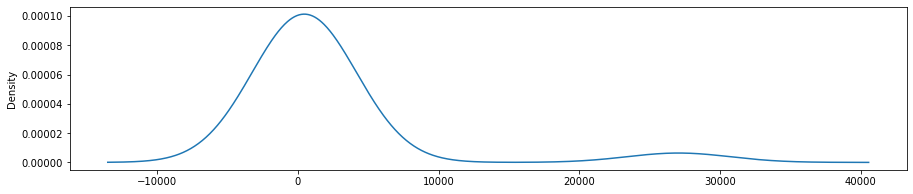

In [11]:
#density plot
AT_count=charity_df['APPLICATION_TYPE'].value_counts()
#AT_count.head(10)
AT_count.plot.density(figsize=(15,3))
# bucket < 5000

In [12]:
# Determine which values to replace if counts are less than ...?
replace_APP = list(AT_count[AT_count < 500].index)

# Replace in dataframe
for app in replace_APP:
    charity_df.APPLICATION_TYPE = charity_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
charity_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [13]:
# Look at CLASSIFICATION value counts for binning
charity_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C1370        1
C6100        1
C8210        1
C1248        1
C2561        1
Name: CLASSIFICATION, Length: 71, dtype: int64

<AxesSubplot:ylabel='Density'>

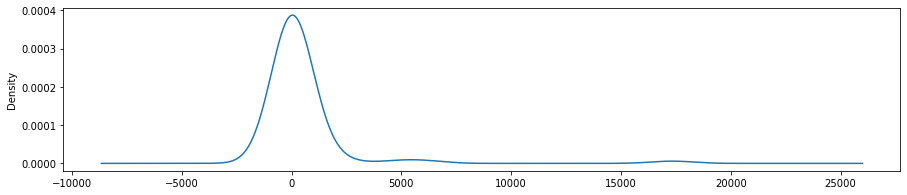

In [14]:
#density plot
CLASS_count=charity_df['CLASSIFICATION'].value_counts()
#CLASS_count.head(10)
CLASS_count.plot.density(figsize=(15,3))
# bucket < 1500

In [15]:
# Determine which values to replace if counts are less than ...?
replace_CLASS = list(CLASS_count[CLASS_count < 1500].index)

# Replace in dataframe
for app in replace_CLASS:
    charity_df.CLASSIFICATION = charity_df.CLASSIFICATION.replace(app,"Other")
    
# Check to make sure binning was successful
charity_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [16]:
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(charity_df[charity_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(charity_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
# Merge one-hot encoded features and drop the originals
charity_df = charity_df.merge(encode_df,left_index=True, right_index=True)
charity_df = charity_df.drop(charity_cat,1)
charity_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
# Split our preprocessed data into our features and target arrays
y = charity_df["IS_SUCCESSFUL"].values
X = charity_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Deliverable 3: Compile, Train and Evaluate the Model with variations

### Option 1: add another hidden layer, 50 epochs

In [20]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.rule of thumb
number_input_features = len(X_train[0])
# https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
hidden_nodes_layer1 =  22
hidden_nodes_layer2 = 11

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 22)                968       
_________________________________________________________________
dense_1 (Dense)              (None, 11)                253       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 12        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames 
# adjust name not to overlay D1/D2 checkpoint files - not 100% required here but I think it is good practice
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights_d3_1.{epoch:02d}.hdf5"

In [23]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4000)

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[cp_callback])

# Evaluate the model using the test data
# model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
804/804 [==============================] - 1s 965us/step - loss: 0.5874 - accuracy: 0.7080
Epoch 2/50
804/804 [==============================] - 1s 792us/step - loss: 0.5585 - accuracy: 0.7269
Epoch 3/50
804/804 [==============================] - 1s 787us/step - loss: 0.5546 - accuracy: 0.7291
Epoch 4/50
804/804 [==============================] - 1s 762us/step - loss: 0.5525 - accuracy: 0.7301
Epoch 5/50
729/804 [==========================>...] - ETA: 0s - loss: 0.5518 - accuracy: 0.7294
Epoch 00005: saving model to checkpoints\weights_d3_1.05.hdf5
804/804 [==============================] - 1s 789us/step - loss: 0.5514 - accuracy: 0.7299
Epoch 6/50
804/804 [==============================] - 1s 782us/step - loss: 0.5502 - accuracy: 0.7307
Epoch 7/50
804/804 [==============================] - 1s 811us/step - loss: 0.5492 - accuracy: 0.7311
Epoch 8/50
804/804 [==============================] - 1s 777us/step - loss: 0.5486 - accuracy: 0.7314
Epoch 9/50
804/804 [=================

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5538 - accuracy: 0.7318
Loss: 0.5538219809532166, Accuracy: 0.7317784428596497


### Option 2: Increase the number of neurons in each layer, 50 epoch

In [26]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.rule of thumb
number_input_features = len(X_train[0])
# https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
hidden_nodes_layer1 =  32
hidden_nodes_layer2 = 16

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                1408      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,953
Trainable params: 1,953
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [28]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames 
# adjust name not to overlay D1/D2 checkpoint files - not 100% required here but I think it is good practice
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights_d3_2.{epoch:02d}.hdf5"

In [29]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4000)

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[cp_callback])


Epoch 1/50
804/804 [==============================] - 1s 874us/step - loss: 0.5838 - accuracy: 0.7093
Epoch 2/50
804/804 [==============================] - 1s 874us/step - loss: 0.5561 - accuracy: 0.7292
Epoch 3/50
804/804 [==============================] - 1s 964us/step - loss: 0.5531 - accuracy: 0.7304
Epoch 4/50
804/804 [==============================] - 1s 878us/step - loss: 0.5515 - accuracy: 0.7293
Epoch 5/50
752/804 [===========================>..] - ETA: 0s - loss: 0.5495 - accuracy: 0.7323
Epoch 00005: saving model to checkpoints\weights_d3_2.05.hdf5
804/804 [==============================] - 1s 822us/step - loss: 0.5500 - accuracy: 0.7315
Epoch 6/50
804/804 [==============================] - 1s 807us/step - loss: 0.5489 - accuracy: 0.7313
Epoch 7/50
804/804 [==============================] - 1s 799us/step - loss: 0.5480 - accuracy: 0.7310
Epoch 8/50
804/804 [==============================] - 1s 780us/step - loss: 0.5472 - accuracy: 0.7324
Epoch 9/50
804/804 [=================

In [30]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5559 - accuracy: 0.7303
Loss: 0.5559237599372864, Accuracy: 0.7302623987197876


### Option 3: Increase to 200 epoch

In [32]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.rule of thumb
number_input_features = len(X_train[0])
# https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
hidden_nodes_layer1 =  32
hidden_nodes_layer2 = 16

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1408      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 1,953
Trainable params: 1,953
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [34]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames 
# adjust name not to overlay D1/D2 checkpoint files - not 100% required here but I think it is good practice
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights_d3_3.{epoch:02d}.hdf5"

In [35]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4000)

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=200,callbacks=[cp_callback])


Epoch 1/200
804/804 [==============================] - 1s 984us/step - loss: 0.5767 - accuracy: 0.7173
Epoch 2/200
804/804 [==============================] - 1s 915us/step - loss: 0.5571 - accuracy: 0.7293
Epoch 3/200
804/804 [==============================] - 1s 919us/step - loss: 0.5537 - accuracy: 0.7298
Epoch 4/200
804/804 [==============================] - 1s 921us/step - loss: 0.5507 - accuracy: 0.7302
Epoch 5/200
731/804 [==========================>...] - ETA: 0s - loss: 0.5486 - accuracy: 0.7318
Epoch 00005: saving model to checkpoints\weights_d3_3.05.hdf5
804/804 [==============================] - 1s 915us/step - loss: 0.5499 - accuracy: 0.7311
Epoch 6/200
804/804 [==============================] - 1s 791us/step - loss: 0.5493 - accuracy: 0.7304
Epoch 7/200
804/804 [==============================] - 1s 789us/step - loss: 0.5484 - accuracy: 0.7318
Epoch 8/200
804/804 [==============================] - 1s 789us/step - loss: 0.5470 - accuracy: 0.7317
Epoch 9/200
804/804 [========

804/804 [==============================] - 1s 764us/step - loss: 0.5354 - accuracy: 0.7402
Epoch 123/200
804/804 [==============================] - 1s 773us/step - loss: 0.5350 - accuracy: 0.7403
Epoch 124/200
804/804 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.73 - 1s 758us/step - loss: 0.5353 - accuracy: 0.7395
Epoch 125/200
263/804 [========>.....................] - ETA: 0s - loss: 0.5359 - accuracy: 0.7366
Epoch 00125: saving model to checkpoints\weights_d3_3.125.hdf5
804/804 [==============================] - 1s 978us/step - loss: 0.5358 - accuracy: 0.7389
Epoch 126/200
804/804 [==============================] - 1s 935us/step - loss: 0.5354 - accuracy: 0.7400
Epoch 127/200
804/804 [==============================] - 1s 777us/step - loss: 0.5348 - accuracy: 0.7403
Epoch 128/200
804/804 [==============================] - 1s 770us/step - loss: 0.5355 - accuracy: 0.7400
Epoch 129/200
804/804 [==============================] - 1s 761us/step - loss: 0.5348 - a

In [36]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5644 - accuracy: 0.7276
Loss: 0.5644029974937439, Accuracy: 0.727580189704895


In [37]:
# Export our model to HDF5 file
# update the name 
nn.save("AlphabetSoupCharity_Optimized_3.h5")